# Benchmarking and Profiling

Benchmarking and Profiling are crucial techniques used to quantify the performance of code and measure improvements in its execution. In Python, understanding the performance of different implementations or comparing the efficiency of algorithms is essential, especially in scenarios where optimization is vital.

When trying to optimize code, it is important to remember that the time required to optimize the code, might be better spent on other tasks. This is to say, when developing code the primary goal is to deliver working code. Delivering fast and efficent code is a secondary goal. With this in mind, it is important not to prematurely optimize code. One can spend an incredible ammount of time trying to optimize code before it even works! Futhermore, one could spend house of work to save only seconds of run time. A balance needs to be struck!

A suitable development workflow would look something like this:
1. **Get a working instance of the code.**
2. Determine suitable benchmarks for evaluating the code (run time, iterations/second, iterations/cpu cores, percision on output, memory usage etc), and set target performance goals (e.g. total run time, total memory budget, etc).
3. Evaluate the performance using the **predefined** benchmarks.
4. **If performance goals aren't met**, profile the code to determine where the bottle necks are and whether changes can be made.
5. Implement suitable changes to the code and repeat from step 3.

Optimizing code can be a very time consuming process. There is a balance that needs to be made between acceptable run time and developer hours needed. Making mulitple changes to the code at once can also introduce bugs that might be difficult to debug. Either make small iterative changes to the code, or make sure the code passes pre-defined tests after each development cycle.

Python provides the `timeit` module, which enables the measurement of execution time for specific code segments. This module offers a simple yet effective way to evaluate the performance of individual code snippets or functions:

* `%%time` will time the contents of an entire cell with a single run
* `%%timeit` will time the contents of an entire cell, averaging over multiples run of that cell
* `%time` will time a signle line with a single run
* `%timeit` will time a single line, averaging over multiples run of that cell


`timeit` will also suspend some features, such as the garbage collector, to get an accurate measurement of the code's runtime.

In [ ]:
import time
import timeit
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
%%timeit
test = 0
for i in range(100000):
    test += 1

We can also measure the time of the cell from one iteration using `%%time`

In [ ]:
%%time
test = 0
for i in range(100000):
    test += 1

We see a number of different times listed here:
* `Wall time`: This is the time that has passed during the running of the code
* `CPU time`: This is the time that the CPU was busy. This also includes time when the CPU has "swapped" its attention to a different process.
* `user`: This is the time that the process has been running on the CPU but outside of the system kernel
* `sys` : This is the time taken inside the system kernel. This could indicate that the code requires a lot of system calls rather than calls written by the developer.

As a rule of thumb:
* CPU Time / Wall Time ~ 1. The process spent most of it's time using the CPU. A faster CPU could improve performance.
* CPU Time / Wall Time < 1. This suggest the process has spent time waiting. This could be resource allocations, network/hardware IO, locks (to prevent data races) etc. The smaller the number, the more time spent waiting. 0.9 would suggest 10% of the time the CPU is idle.
* CPU Time / Wall Time > 1. This suggests that we are utilizing multiple processors when running our code.


If we are running with N processors:
* CPU Time / Wall Time ~ N. The process is well distributed across all CPUs with little to no idle time.
* CPU Time / Wall Time < N. This suggest the process has spent time waiting. This could be resource allocations, network/hardware IO, locks (to prevent data races) etc.

We can use `%timeit` to time an single line or process, averaging over multiple runs:

In [ ]:
print ("This line won't be timed")
# Either will this line
test = np.random.random(1000)
# This line will be timed
%timeit test = np.random.random(1000)

Or we can use `%time` to time an single line or process, with no averaging:

In [ ]:
print ("This line won't be timed")
# Either will this line
test = np.random.random(1000)
# This line will be timed
%time test = np.random.random(1000)

Let's look at comparing two functions. Consider vector addition. In a pure Python, we would use a for loop to iterate over each element. We could also use numpy's inbuild functions to perform the addition/

In [ ]:
def add_two_arrays(a : np.ndarray,b : np.ndarray) -> np.ndarray:
    """Add two numpy arrays togeter using a for loop

    Args:
        a : array 1 to be added
        b : array 2 to be added

    Returns:
        array of a + b
    """
    c = np.zeros(len(a))
    for i in range(len(a)):
        c[i] = a[i] + b[i]
    return c

def add_two_arrays_numpy(a : np.ndarray, b : np.ndarray) -> np.ndarray:
    """Add two numpy arrays togeter using vectorization

    Args:
        a : array 1 to be added
        b : array 2 to be added

    Returns:
        array of a + b
    """
    c = a + b
    return c

In [ ]:
test_x = np.random.random(1000)
test_y = np.random.random(1000)

print("Pure Python:")
%timeit test_z = add_two_arrays(test_x, test_y)
print("Numpy:")
%timeit test_z = add_two_arrays_numpy(test_x, test_y)


We see a dramatic improvement by using NumPy arrays to add two vectors together. This is because NumPy is a highly optimized library, with the low-level code written in C++. Is this always the case?

In [ ]:
def time_addition(n):
    
    test_x = np.random.random(n)
    test_y = np.random.random(n)
    
    n_repeat = 10
    
    # pure python
    t_start = time.time()
    for _ in range(n_repeat):
        _ = add_two_arrays(test_x, test_y)
    t_pure = np.median(time.time() - t_start)

    # numpy
    t_start = time.time()
    for _ in range(n_repeat):
        _ = add_two_arrays_numpy(test_x, test_y)
    t_numpy = np.median(time.time() - t_start)

    return t_pure, t_numpy

In [ ]:
n_array = np.arange(20)
times_py = np.zeros(n_array.shape)
times_np = np.zeros(n_array.shape)

for i, n in enumerate(n_array):
    times_py[i], times_np[i] = time_addition(int(2**n))



In [ ]:
plt.plot(2 ** n_array, times_py, "C0s:", label = "Pure Python")
plt.plot(2 ** n_array, times_np, "C1o--", label = "Numpy")
plt.loglog()
plt.grid()
plt.legend()
plt.xlabel("Array Length")
plt.ylabel("Run Time [s]");



At very small array sizes the performance is comparable. This is likely due to the overhead of calling the low level NumPy code. The NumPy perfomance saturates around $10^2$ - $10^3$ before scaling in a comparatable fashion to pure python, however it is still orders of magnitude faster. This perfomance will be system dependent!

It might be easy to assume for the above example that NumPy is always better than pure Python, but this isn't always the case and we should always consider our specific needs.

If we where writing code to operate on small (O($10^1$)), we may be faster to use a pure python implementation rather than importing NumPy and introducing an additional overhead.


## Line profiling

Line profiling is a useful tool for finding bottlenecks within a block of code. There are many profilers one can use:
* cProfiles
* line_profiler
* todo get more

For this example, we'll use line_profiler
```
mamba/conda install line_profiler
```
or 

```
pip install line_profiler
```

Let's look at an expensive function that uses a MC method to estimate $\pi$.

We're going to throw random points $x, y \in [0,1]$ into a square of length 1. This will give an estimate of the the area of the square:

$$ A_{square} \propto N_{total}$$
The area of a circle is given by:
$$ A_{circle} = \pi r^2$$
Since we're throwing random numbers in the range $[0,1]$, we will fill a quatre of a circle. 
$$ A_{circle} \propto 4 * \tilde{N_{within}}$$
Where $\tilde{N_{within}}$ is the number of samples within 1 of the origin (or $x^2 + y^2 <1$).

Combing these, we can estimate $pi$ as:
$$ \pi \approx 4 \frac{N_{within}}{N_{total}}$$


In [ ]:
def monte_carlo_pi(nsamples):
    acc = 0
    for i in range(nsamples):
        x = np.random.random()
        y = np.random.random()
        if (x ** 2 + y ** 2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

In [ ]:
n_range = np.arange(7)

pi_diff = [np.abs(np.pi - monte_carlo_pi(10**n)) for n in n_range]

In [ ]:
plt.plot(10**n_range, pi_diff)
plt.xlabel("Number of Random Samples")
plt.ylabel("$|\pi_{NumPy} - \pi_{MC}|$")
plt.grid()
plt.xscale('log')
#plt.yscale('log')

We can see that as $N_{total}$ increases we tend to the NumPy value of $\pi$. We obtain deminising returns at around $10^4$ samples. Let's choose this as our benchmark point.

In [ ]:
n_total = 10 ** 4

How long does this take to run?

In [ ]:
%timeit monte_carlo_pi(n_total)

In [ ]:
n_run = 100
n_repeat = 10
t_original = np.array(
    timeit.repeat(f"monte_carlo_pi({n_total})", "from __main__ import monte_carlo_pi", repeat = n_repeat,  number = n_run)
) / n_run

In [ ]:
print(f"Original Runtime = {np.mean(t_original) : 0.2e} +/- {np.std(t_original) :0.2e} s") 

If we want to speed up this calculation, we should first find what is the major bottleneck.

In [ ]:
%load_ext line_profiler

In [ ]:
%lprun -f monte_carlo_pi monte_carlo_pi(n_total)

The above shows a breakdown of where we're spending time. We have each line of the function broken down. We can see that the allocations of `acc` and the return of `4.0 * acc / nsamples` are expensive operations, but this only happens once per execution. Since these only happen once there may be some "noise" effecting these estimates. 

`for i in range(nsamples):` takes 8% of our time. This is pretty significant. Python is also nutoriously bad at looping. If we can avoid looping in Python we should.

We also see that `acc += 1` doesn't happen every iteration, and we spend ~20% of our time checking `if (x ** 2 + y ** 2) < 1.0`. We can see that the dominate part of the time is spent generating random numbers (`x/y = np.random.random()`) which takes ~60% of the run time. 

If we were looking to speed up this function, we should work target the most expensive parts first, this would suggest targeting:
```
        x = np.random.random()
        y = np.random.random()
        if (x ** 2 + y ** 2) < 1.0:
```
Which constitutes 80% or our run time. Since these are ran 10000 times, it might make more sense to somehow only run this once. But how...

In [ ]:
def monte_carlo_pi_pure_numpy(nsamples):


In [ ]:
%timeit monte_carlo_pi_pure_numpy(n_total)

In [ ]:
n_run = 1000
n_repeat = 10
t_optimized = np.array(
    timeit.repeat(f"monte_carlo_pi_pure_numpy({n_total})", "from __main__ import monte_carlo_pi_pure_numpy", repeat = n_repeat,  number = n_run)
) / n_run
t_optimized

In [ ]:
print(f"Optimized Runtime = {np.mean(t_optimized) : 0.2e} +/- {np.std(t_optimized) :0.2e} s") 

In [ ]:
%lprun -f monte_carlo_pi_pure_numpy monte_carlo_pi_pure_numpy(n_total)

In [ ]:
speedup =  np.mean(t_original) / np.mean(t_optimized)
print (f"Optmization speeds up the code by a factor of {speedup:0.2f}")

## Can we do better?

We're already using highly optimized NumPy which is based on C/C++ code. However we're still interpting slow bytecode at run time and running on one core.

In [ ]:
# !pip install numba

In [ ]:
from numba import jit

In [ ]:
def monte_carlo_pi_pure_numpy_jit(nsamples):


In [ ]:
t1 = time.time()
monte_carlo_pi_pure_numpy_jit(n_total)
telap = time.time() - t1
print (f"This took {telap}s")

In [ ]:
t1 = time.time()
monte_carlo_pi_pure_numpy_jit(n_total)
telap = time.time() - t1
print (f"This took {telap}s")

In [ ]:
n_run = 1000
n_repeat = 10
t_jitted = np.array(
    timeit.repeat(f"monte_carlo_pi_pure_numpy_jit({n_total})", "from __main__ import monte_carlo_pi_pure_numpy_jit", repeat = n_repeat,  number = n_run)
) / n_run
# t_jitted

In [ ]:
print(f"jitted Runtime = {np.mean(t_jitted) : 0.2e} +/- {np.std(t_jitted) :0.2e} s") 

In [ ]:
speedup =  np.mean(t_original) / np.mean(t_jitted)
print (f"Optmization speeds up the code by a factor of {speedup:0.2f}")

In [ ]:
def monte_carlo_pi_pure_numpy_jit_parallel(nsamples):


In [ ]:
t1 = time.time()
monte_carlo_pi_pure_numpy_jit_parallel(n_total)
telap = time.time() - t1
print (f"This took {telap}s")

In [ ]:
n_run = 10000
n_repeat = 10
t_jitted_parallel = np.array(
    timeit.repeat(f"monte_carlo_pi_pure_numpy_jit_parallel({n_total})", "from __main__ import monte_carlo_pi_pure_numpy_jit_parallel", repeat = n_repeat,  number = n_run)
) / n_run
t_jitted_parallel

In [ ]:
print(f"jitted parallel Runtime = {np.mean(t_jitted_parallel) : 0.2e} +/- {np.std(t_jitted_parallel) :0.2e} s") 

In [ ]:
speedup =  np.mean(t_original) / np.mean(t_jitted_parallel)
print (f"Optmization speeds up the code by a factor of {speedup:0.2f}")

In [ ]:
def monte_carlo_pi_pure_numpy_jit_parallel_nopython(nsamples):


In [ ]:
t1 = time.time()
monte_carlo_pi_pure_numpy_jit_parallel_nopython(n_total)
telap = time.time() - t1
print (f"This took {telap}s")

In [ ]:
n_run = 10000
n_repeat = 10
t_jitted_parallel_nopython = np.array(
    timeit.repeat(f"monte_carlo_pi_pure_numpy_jit_parallel_nopython({n_total})", "from __main__ import monte_carlo_pi_pure_numpy_jit_parallel_nopython", repeat = n_repeat,  number = n_run)
) / n_run
t_jitted_parallel_nopython

In [ ]:
print(f"jitted parallel no python Runtime = {np.mean(t_jitted_parallel_nopython) : 0.2e} +/- {np.std(t_jitted_parallel_nopython) :0.2e} s") 

In [ ]:
speedup =  np.mean(t_original) / np.mean(t_jitted_parallel_nopython)
print (f"Optmization speeds up the code by a factor of {speedup:0.2f}")

In [ ]:
def monte_carlo_pi_revisit(nsamples):


In [ ]:
t1 = time.time()
monte_carlo_pi_revisit(n_total)
telap = time.time() - t1
print (f"This took {telap}s")

In [ ]:
n_run = 10000
n_repeat = 10
t_jitted_revisit = np.array(
    timeit.repeat(f"monte_carlo_pi_revisit({n_total})", "from __main__ import monte_carlo_pi_revisit", repeat = n_repeat,  number = n_run)
) / n_run
t_jitted_revisit

In [ ]:
print(f"jitted parallel no python Runtime = {np.mean(t_jitted_revisit) : 0.2e} +/- {np.std(t_jitted_revisit) :0.2e} s") 

In [ ]:
speedup =  np.mean(t_original) / np.mean(t_jitted_revisit)
print (f"Optmization speeds up the code by a factor of {speedup:0.2f}")

### Summary

We've looked at both how to speed up a simple function by first using pure NumPy, then moving to compiled versions, before moving to a parallel implementation:

In [ ]:
speedup =  np.mean(t_original) / np.mean(t_optimized)
print (f"Pure NumPy speeds up the code by a factor of {speedup:0.2f}")

speedup =  np.mean(t_original) / np.mean(t_jitted)
print (f"Compiled NumPy speeds up the code by a factor of {speedup:0.2f}")

speedup =  np.mean(t_original) / np.mean(t_jitted_parallel)
print (f"Parallel annd compiled NumPy speeds up the code by a factor of {speedup:0.2f}")

speedup =  np.mean(t_original) / np.mean(t_jitted_parallel_nopython)
print (f"Parallel annd compiled NumPy with 'no python' speeds up the code by a factor of {speedup:0.2f}")

speedup =  np.mean(t_original) / np.mean(t_jitted_revisit)
print (f"Parallel and complied python speeds up the code by a factor of {speedup:0.2f}")

The compiled and parallel implementations offer the best performance. If we don't have access to a multi-core system, we achieve x100 performace by simply compiling the function with numba and jit. 

## Memory Profiling

So far we've only considered the run time performance. This is only one aspect of performance. Memory usage is often a limiting factor in performance. 

We can use the `memory_profile` to profile the memory of our code. This works by sampling the memory usage at intervals while the code is running.

Similar to `%%timeit` and `%timeit` we can use `%%memit` and `%memit` to get the memory usage of a cell and a single line.

In [ ]:
# if you have issues with async switch to v0.61
# pip install memory_profiler==0.61

In [1]:
%load_ext memory_profiler
# to automatically reload changed files
%load_ext autoreload
%autoreload 2

In [2]:
%memit big_array = [i for i in range(10**7)]

peak memory: 445.73 MiB, increment: 383.50 MiB


If we want to try and find what processes are using a lot of memory, we can line profile a function.

In [3]:
%%writefile function_to_profile.py
import time

def expensive_function():
    
    x = [ 120 for i in range(100) ]
    b = [ x * 100 for i in range(1000) ]
    big_list = [ i for i in range(10**5) ]
    another_big_list = [ i for i in range(10**5) ]
    time.sleep(0.01)

    x = [ 42 for i in range(1000) ] 

Overwriting function_to_profile.py


In [4]:
from function_to_profile import expensive_function
%mprun -f expensive_function expensive_function()

Filename: /home/obriens/Documents/websites/mcgill_site/docs/Tutorials/Python/function_to_profile.py

Line #    Mem usage    Increment  Occurrences   Line Contents
     3    446.0 MiB    446.0 MiB           1   def expensive_function():
     4                                             
     5    446.0 MiB      0.0 MiB         103       x = [ 120 for i in range(100) ]
     6    522.0 MiB     76.0 MiB        1003       b = [ x * 100 for i in range(1000) ]
     7    525.6 MiB      3.6 MiB      100003       big_list = [ i for i in range(10**5) ]
     8    530.2 MiB      4.6 MiB      100003       another_big_list = [ i for i in range(10**5) ]
     9    530.2 MiB      0.0 MiB           1       time.sleep(0.01)
    10                                         
    11    530.2 MiB      0.0 MiB        1003       x = [ 42 for i in range(1000) ]

This can often be difficult to parse and understand, in a jupyter notebook. I prefer to use `memory_profiler` via the command line interface (which we can still call from jupyter!).

In [5]:
%%writefile initial_code.py

import numpy as np
import pandas as pd
import time

@profile
def load_data():
    df = pd.read_csv("./gaia3.csv")
    return df

@profile
def filter_data(df):
    parallax = df["parallax"]
    parallax_err = df["parallax_over_error"]
    good_mask = parallax_err > 20
    return good_mask
    
@profile
def get_distance(df):
    distance = 1./ (df["parallax"] * 1e-3)
    return distance

@profile
def assign_distance(df, distance):
    df["distance"] = distance



@profile
def filter_distance(df):
    distance = df["distance"]
    good_mask = distance < 10
    return good_mask


@profile
def apply_filter(df, data_filter):
    data = df[data_filter]
    return data



if __name__ == '__main__':

    data = load_data()
    time.sleep(0.1)
    
    data_filter = filter_data(data)
    time.sleep(0.1)
    
    data_filtered = apply_filter(data, data_filter)
    time.sleep(0.1)
    
    distance = get_distance(data_filtered)
    time.sleep(0.1)
    
    assign_distance(data_filtered, distance)
    time.sleep(0.1)
    
    distance_filter = filter_distance(data_filtered)
    time.sleep(0.1)
    
    data_10pc = apply_filter(data_filtered, distance_filter)
    time.sleep(0.1)




Overwriting initial_code.py


In [6]:
!mprof run --interval 0.005 --python python initial_code.py
!mprof plot --output initial_code_profile.png

mprof: Sampling memory every 0.005s
running new process
running as a Python program...
initial_code.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["distance"] = distance
Using last profile data.


In [7]:
from IPython.display import Image, display

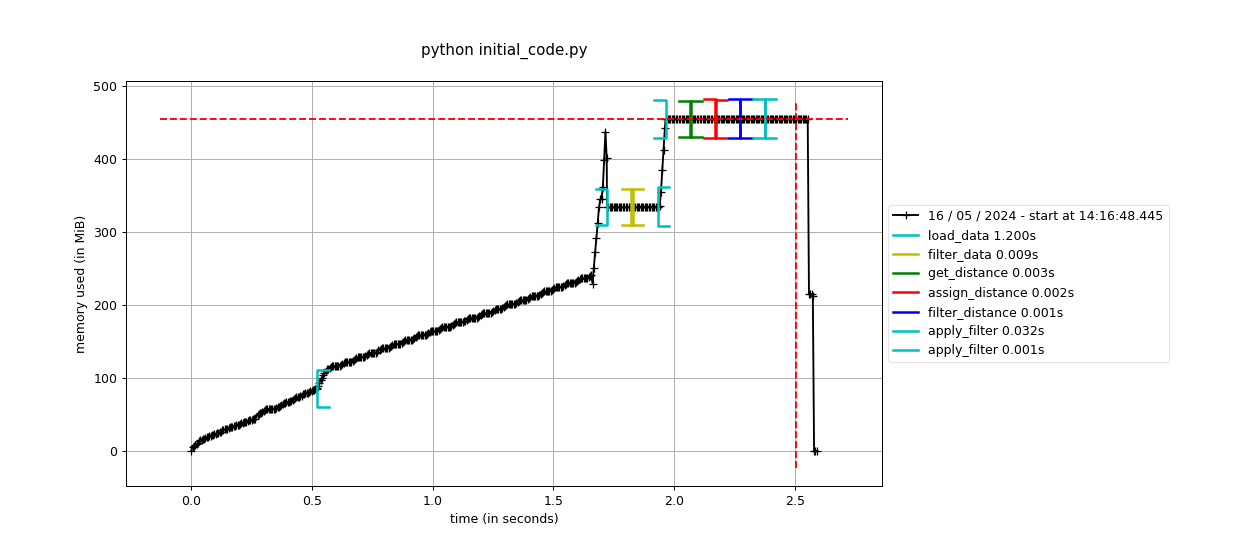

In [8]:
display(Image("./initial_code_profile.png"))

From the above we can see a few things:

1. The file we read in is pretty big. The dataframe takes up ~250 MiB.
2. Filtering the data has a negligable effect on the memory usage.
3. We see a huge spike when calling `apply_filter` for the first time.
4. We see a second smaller spike when calling `get_distance`.


A plot like this is useful when we're trying to decide on what resources we need to run this program. We could likely run this on most machines as ~400 MiB is attainable by most personal laptops. **If we wanted to submit this job to a cluster, we'd want at least ~450 MiB to provide some breathing room.**


If we want to target areas to reduce memory usage, we should target the `apply_filter` and `get_distance` functions. Additionally we can look at ways to reduce the dataset size (we'll come back to this...).

Let's look at `apply_filter`:

```python
@profile
def apply_filter(df, data_filter):
    data = df[data_filter]
    return data
...
    data_filtered = apply_filter(data, data_filter)
...
    data_10pc = apply_filter(data_filtered, distance_filter)
...
```

We are using the `apply_filter`. This function takes in a `pandas.dataframe` and a boolean array and returns a new `pandas.dataframe`. Let's start by overwriting the data in the function:
```python

@profile
def apply_filter(df, data_filter):
    df = df[data_filter]
    return df
```

Additionally we'll overwrite all the instances of `data`

In [13]:
%%writefile initial_code_iteration1.py

import numpy as np
import pandas as pd
import time

@profile
def load_data():
    df = pd.read_csv("./gaia3.csv")
    return df

@profile
def filter_data(df):
    parallax = df["parallax"]
    parallax_err = df["parallax_over_error"]
    good_mask = parallax_err > 20
    return good_mask
    
@profile
def get_distance(df):
    distance = 1./ (df["parallax"] * 1e-3)
    return distance

@profile
def assign_distance(df, distance):
    df["distance"] = distance



@profile
def filter_distance(df):
    distance = df["distance"]
    good_mask = distance < 10
    return good_mask


@profile
def apply_filter(df, data_filter):
    df = df[data_filter]
    return df



if __name__ == '__main__':

    data = load_data()
    time.sleep(0.1)
    
    data_filter = filter_data(data)
    time.sleep(0.1)
    
    data_filtered = apply_filter(data, data_filter)
    time.sleep(0.1)
    
    distance = get_distance(data_filtered)
    time.sleep(0.1)
    
    assign_distance(data_filtered, distance)
    time.sleep(0.1)
    
    distance_filter = filter_distance(data_filtered)
    time.sleep(0.1)
    
    data_10pc = apply_filter(data_filtered, distance_filter)
    time.sleep(0.1)




Overwriting initial_code_iteration1.py


In [14]:
!mprof run --interval 0.005 --python python initial_code_iteration1.py
!mprof plot --output initial_code_iteration1.png

mprof: Sampling memory every 0.005s
running new process
running as a Python program...
initial_code_iteration1.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["distance"] = distance
Using last profile data.


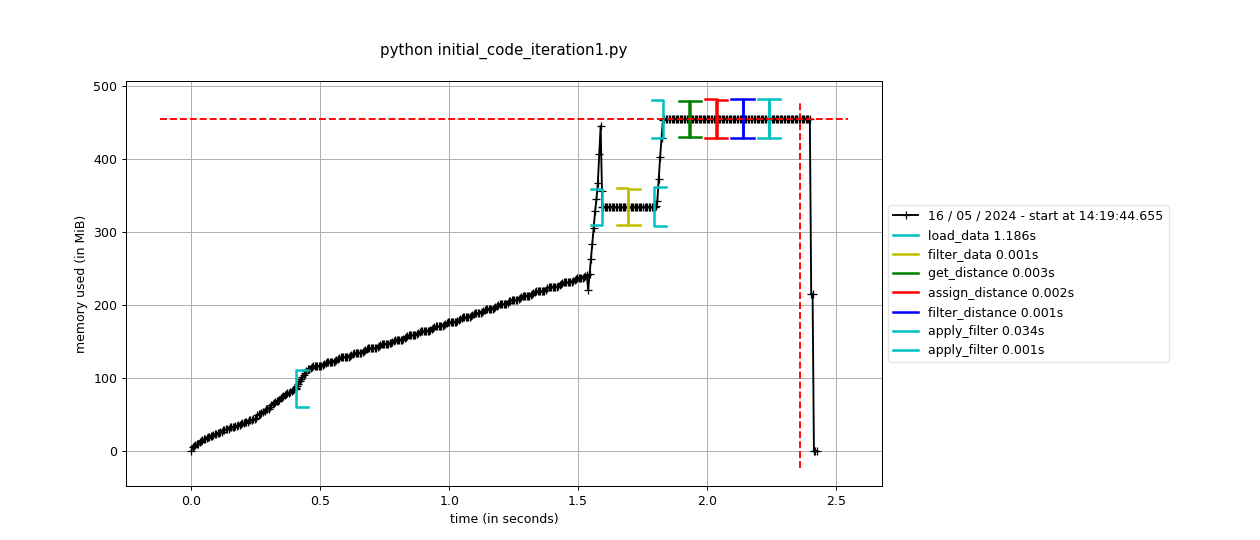

In [15]:
display(Image("./initial_code_iteration1.png"))

This is an improvement, but we still see a spike at ~400 MiB when `apply_filter` is called for the first time. Why is this? Let's look at the function again:

```python
def apply_filter(df, data_filter):
    df = df[data_filter]
    return df
```


When calling `df = df[data_filter]` we first make a copy of the data using `df[data_filter]` before assigning it to `df`. Let's look at a more memory efficient way to do this:

```python
def apply_filter(df, data_filter):
    # Assign NaN to all the RA of the filtered events
    df["ra"][data_filter] = np.nan
    # Drop the entries with NaN, inplace = True meaning overwrite
    df.dropna(inplace = True)
```

Since we've overwritten the original dataframe, we don't need to return anything...



In [ ]:
%%writefile initial_code_iteration2.py


In [ ]:
!mprof run --interval 0.005 --python python initial_code_iteration2.py
!mprof plot --output initial_code_iteration2.png

In [ ]:
display(Image("./initial_code_iteration2.png"))

This looks a lot better, but we still have that inital overhead of the dataset, is there anything we can do here?

Let's look at the data.

In [ ]:
!head gaia3.csv

We have a lot of percision in our measurements. Lets compare the measured values to the uncertainty on these values. Let's limit ourself to the first 100 values. By default, `pandas` will use 64 bit percision when reading in floats. This might be overkill.

In [ ]:
import pandas as pd
df = pd.read_csv("gaia3.csv", nrows=100)
df.head()

Do we need this percision? In this case it looks like the errors on our data are already pretty large.

In [ ]:
import numpy as np
df_f32 = pd.read_csv("gaia3.csv", nrows=100, dtype=np.float32)
df_f32.head()

In [ ]:
import matplotlib.pyplot as plt
plt.hist(df["parallax"] - df_f32["parallax"])

In [ ]:
df_f16 = pd.read_csv("gaia3.csv", nrows=100, dtype=np.float16)
df_f16.head()

In [ ]:
plt.hist(df["parallax"] - df_f16["parallax"])

For a 32 bit float the uncertainy introduce is O($10^{-7}$), whereas for a 16 bit float the uncertainy is O($10^{-3}$).  Let's start off by looking at using 32 bit floats instead when creating the pandas dataframe:

```python
def load_data():
    df = pd.read_csv("./gaia3.csv", dtype = np.float32)
    return df
```

In [ ]:
%%writefile initial_code_iteration3.py


In [ ]:
!mprof run --interval 0.005 --python python initial_code_iteration3.py
!mprof plot --output initial_code_iteration3.png

In [ ]:
display(Image("./initial_code_iteration3.png"))

We see a big improvement, with the peak memory usage < 250 MiB. Since we're limited by the uncertinty in the measurements, we might decide to lower our precision again:
```python
def load_data():
    df = pd.read_csv("./gaia3.csv", dtype = np.float16)
    return df
```

In [ ]:
%%writefile initial_code_iteration4.py


In [ ]:
!mprof run --interval 0.005 --python python initial_code_iteration4.py
!mprof plot --output initial_code_iteration4.png

In [ ]:
display(Image("./initial_code_iteration4.png"))

Before we start reading the the dataframe we already have ~75 MiB. Can we reduce this?

NumPy is a pretty big library, let's only import what we need.

In [ ]:
%%writefile initial_code_iteration5.py


In [ ]:
!mprof run --interval 0.005 --python python initial_code_iteration5.py
!mprof plot --output initial_code_iteration5.png

In [ ]:
display(Image("./initial_code_iteration5.png"))

This brings us below 175 MiB. There are other steps we could look at:

* Running in batches to reduce the overall usage.
* Only loading in the columns needed for analysis
* Using a different package/backend?

## Summary

We're managed to reduce the memory usage from ~450 MiB to < 175 MiB. We achieved this by:

* Profiling the memory usage to see what to target
* Avoiding copying the data
* Using inbuild functions to delete elements rather than doing by copy
* Changing the percision of the data we're using
* Reducing the import overhead

There is still a lot of redundency in the above code, we could explore other options:

* Rewriting parts of the code in more memory efficient languages (Rust, C++). 
* Reducing the import overhead by reducing the complexity of the code and doing more steps in pure python.
* Using more memory efficient libraries (e.g. Polars).
* Spliting the dataset into chunks and loading in smaller bits at a time.

We also need to consider the development cost in finding low-memory solutions. Reducing the memory usage by 10% might be better than spending hours trying to reduce it by 20%. 

The methods we've used here also have trade offs:
* Going from f64 -> f16 is a lossy form of compression. We have lost information that we cannot simply get back.
* We've thrown away data after it's read in and filtered. We can no longer compare to the original dataset without rewriting code.
* We've decreased the complexity, we can no longer access functions like `numpy.sum` without explicitly importing them first.

When working with clusters we can use tools such as `memory_profiler` to estimate the requirements of the job we're about to submit. This can prevent our job crashing if we haven't requested enough memory.





## Cheap Tricks to "generally" speed up your code

### Vectorization is your friend

Vecorizing functions allow them to be applied to NumPy arrays, without having to write a for loop.

In [ ]:
def if_function(x):
    if x < 0:
        return 0
    else:
        return np.sqrt(x)


In [ ]:
x = np.random.random(10**5)

In [ ]:
%timeit y = if_function(x)

We might be tempted to simply rewrite this function with a for loop. But remember, Python is terrible when looping...

In [ ]:
def loop_function(x):
    ret = np.zeros(len(x))
    for i in range(len(x)):
        if x[i] < 0:
            ret[i] =  0
        else:
            ret[i] = np.sqrt(x[i])
    return ret 

In [ ]:
%timeit y = loop_function(x)

In [ ]:
vec_function = np.vectorize(if_function)

In [ ]:
%timeit y = vec_function(x)

### Caching frequently used function calls
When you're expecting to repeat function calls with the same arguements, cache the results.

In [ ]:
#first in first out cache wrapper
def fifo(func):
    # Define the cache size 
    cache_size = 5
    # Use a dictionary as the cache
    cache = {}

    def wrapper(*args, **kwargs):
        # tokenize the arguments
        token = ""
        for arg in args:
            token += str(arg)
        for arg in kwargs:
            token += str(arg)

        # If still have the token
        if token in cache:
            return cache[token]

        # Call function
        result = func(*args, **kwargs)
        cache[token] = result

        # Check if we need to remove items from cache
        if len(cache) > 5:
            cache[next(iter(cache))]
            
        # Return the results of the function
        return result
    return wrapper

In [ ]:
def multiply_string(my_string, rept):
    time.sleep(0.5)
    return my_string * rept



In [ ]:
%time multiply_string("hello", 5)


In [ ]:
%time multiply_string("hello", 5)

In [ ]:
@fifo
def multiply_string_cache(my_string, rept):
    time.sleep(0.5)
    return my_string * rept

In [ ]:
%time multiply_string_cache("goodbye", 5)


In [ ]:
%time multiply_string_cache("goodbye", 5)

Now that we know how the cache works, we can use some blackboxed python functions.

Let's use a [Least recently used](https://en.wikipedia.org/wiki/Cache_replacement_policies#Least_recently_used_(LRU)) cache. This will track the number of times we call a set of args. When the cache fills up, the least used item will be removed.

In [ ]:
from functools import lru_cache

@lru_cache(maxsize=5)
def multiply_string_lru(my_string, rept):
    time.sleep(0.5)
    return my_string * rept

In [ ]:
%time multiply_string_lru("goodbye", 5)


In [ ]:
%time multiply_string_lru("goodbye", 5)

### Already have working code from a more efficient language? Import it!

Python has lots of tools to import code from different languages

In [ ]:
def py_fib(x):
    if x in [0,1] :
        return 1
    else:
        return py_fib(x - 1) + py_fib(x - 2)


In [ ]:
%timeit py_fib(10)

In [ ]:
from numba import jit

@jit( nopython = True )
def py_fib(x):
    if x in [0,1] :
        return 1
    else:
        return py_fib(x - 1) + py_fib(x - 2)


In [ ]:
py_fib(10)

In [ ]:
%timeit py_fib(10)

We can use packages like Cython to write C++ code in Python. Or we can directly import a precompiled library.

We can make C++ functions accessible in Python by wrapping our code in a `extern "C"` block.

```C++
extern "C" {

    double my_function(... some arguments...){
        ... some code ...
    }
}
```

Why `extern "C"`? One of the differences between C and C++ is that C++ allows us to overload functions. This means that two functions can have the same name, but accept different arguements. For example let say we have some functionality that we would like to make common across different data types:
```C++
double get_sqrt_integer( int a );
double get_sqrt_double( double a );
```

The user shouldn't need to worry if the argument is an `int` or a `double`. So we would "overload" the function like so:
```C++
double get_sqrt( int a );
double get_sqrt( double a );
```
So the user only ever calls `get_sqrt` and the compile handles the logic on whether it is a `double` or an `int`. The compile does this by giving each of the function versions unique names that are generated at compile time.

By using `extern "C"` we are reverting back to the `C` method, which will explicitly asign the name we give the function, but it means that we can no longer overload the function. We therefore would need to run:

```C++
extern "C" {   
    double get_sqrt_integer( int a );
    double get_sqrt_double( double a );
}
```

When analyzing the compiled library we would see the two functions called `get_sqrt_integer` and `get_sqrt_double`.

In [ ]:
%%writefile cpp_fib.cpp
extern "C" {
    int cpp_fib(unsigned int x)
    {
        if ( (x == 0) || (x == 1) )
        {
            return 1;
        }
        else
        {
            return cpp_fib(x-1) + cpp_fib(x-2);
        }
    }
}

Compile to a shared library

In [ ]:
# mamba / conda install gxx
# or
# mamba /conda install gxx-compiler

In [ ]:
! g++ -fPIC -shared -o cpp_fib.so cpp_fib.cpp -O3

In [ ]:
! ls cpp_*

Load in the library with `ctypes` and "translate" the argument types

In [ ]:
import ctypes

cpp_lib = ctypes.CDLL("./cpp_fib.so")
# Access the cpp_fib function from the library
# and assigne the argument type
cpp_lib.cpp_fib.argtypes = [ctypes.c_uint] 
# Alias it to cpp_fib
cpp_fib = cpp_lib.cpp_fib


In [ ]:
%timeit cpp_fib(10)

We can also load in Rust code using rustimport
```
mamba/conda install rustimport
```

And the `pyo3` rust crate:

In [ ]:
%load_ext rustimport

use `--release` to complie an optimized binary rather than a debug binary.

In [ ]:
%%rustimport  --release --force
use pyo3::prelude::*;

#[pyfunction]
fn rust_fib(x: usize) -> usize {
    match x {
        1 => 1,
        0 => 1,
        _ => rust_fib(x - 1) + rust_fib(x - 2)
    }
}

In [ ]:
%timeit rust_fib(10)

In [ ]:
# fib_sqe = [py_fib(i) for i in range(10)]
# fib_sqe

In [ ]:
# fib_sqe = [cpp_fib(i) for i in range(10)]
# fib_sqe

In [ ]:
# fib_sqe = [rust_fib(i) for i in range(10)]
# fib_sqe

### Don't reinvent the wheel!

Python is one of the most popular languages. A lot of super talented people have spent a lot of time optimizing python and wrapping low lower level languages in Python code. Use libraries such as:

* NumPy
* SciPy
* Pandas